In [1]:
import pyPamtra
import datetime
import numpy as np
import pandas as pd
import pickle
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr
get_ipython().run_line_magic('matplotlib', 'inline')

from scipy.stats import pearsonr

import os
import sys

current_path=os.getcwd()
sys.path.insert(1,current_path+"/../src/")


## This is the PAMTRA Simulation Analysis tool

In [2]:
import PAMTRA_sim_analysis as PAMSA
#class PAMTRASIM_analysis():
#    def __init__(self,date="20110317",data_path="/scratch/u/u300737/",hour="12",instrument="hamp"):
#        self.data_path=data_path
#        self.date_str=date
#        self.hour=hour
#        self.instrument=instrument
#    def open_era5_fields(self):
 #       self.era5_fname="era5_"+self.date_str+"_"+self.hour+"_atmos.nc"
#        self.era5_ds=xr.open_dataset(self.data_path+self.era5_fname)
#    def open_era5_tbs(self):
#        self.pamtra_fname="pamtra_"+self.instrument+"_"+self.date_str+"_"+self.hour+".nc"
#        self.pamtra_ds=xr.open_dataset(self.data_path+self.pamtra_fname)
    #def cut_era5_to_open_ocean():
    #    pass
    #def open_era5_tbs_ocean(self):
    #    self.open_era5_tbs()
     #   self.cut_era5_to_open_ocean

In [10]:
date_to_analyse='19790312'
sim_cls=PAMSA.PAMTRASIM_analysis(data_path="/work/bb1320/hdorff/pamtra_hamp_retrieval/",date=date_to_analyse)
sim_cls.open_era5_fields()#.era5_ds
era5_ds=sim_cls.era5_ds
# Take the 16 km height data
height_idx=1
relevant_height=era5_ds["obs_height"][height_idx]

array(16000.)

In [28]:
era5_ds#["iwv"][:,:,height_idx]

<xarray.Dataset>
Dimensions:     (x: 346, y: 1, nout: 45, z: 131)
Dimensions without coordinates: x, y, nout, z
Data variables: (12/16)
    unixtime    (x, y) datetime64[ns] ...
    lat         (x, y) float64 ...
    lon         (x, y) float64 ...
    obs_height  (nout) float64 ...
    sfc_slf     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sfc_sif     (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    p           (x, y, z) float64 ...
    iwv         (x, y, nout) float64 ...
    lwp         (x, y, nout) float64 ...
    iwp         (x, y, nout) float64 ...
    rwp         (x, y, nout) float64 ...
    swp         (x, y, nout) float64 ...

In [12]:
land_sea_mask=pd.Series(data=era5_ds["sfc_slf"].values.flatten(),index=range(era5_ds["sfc_slf"].shape[0]))

In [13]:
sea_ice_mask=pd.Series(data=era5_ds["sfc_sif"].values.flatten(),index=range(era5_ds["sfc_sif"].shape[0]))

In [14]:
open_ocean=pd.Series(data=np.zeros(era5_ds["sfc_slf"].shape[0]),index=sea_ice_mask.index)
open_ocean.loc[(land_sea_mask==0) & (sea_ice_mask==0)]=1

### PAMTRA TBs

In [16]:
sim_cls.open_era5_tbs()
tb_ds=sim_cls.pamtra_ds

array([16000., 15400., 15200., 15000., 14800., 14600., 14400., 14200.,
       14000., 13800., 13600., 13400., 13200., 13000., 12800., 12600.,
       12400., 12200., 12000., 11800., 11600., 11400., 11200., 11000.,
       10800., 10600., 10400., 10200., 10000.,  9800.,  9600.,  9400.,
        9200.,  9000.,  8800.,  8600.,  8400.,  8200.,  8000.,  7800.,
        7600.,  7400.,  7200.,  7000.])

In [22]:
#cut to relevant data
tb_ds=sim_cls.pamtra_ds.isel({#"x":":",
                              "y":0,
                              "nout":height_idx-1,
                              "nang":0})
tb_da=tb_ds["tb"].mean(axis=2)
tb_da=tb_da.assign_coords(freq=tb_ds.freq)
tb_da=tb_da.isel(nfreq=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,
                        20,21,22,23,33,34,35,36,37])
#tb_da

## So far only consider open sea values

#### Plot path

In [23]:
import os 
plot_path=os.getcwd()+"/plots/"
ar_plot_path=plot_path+"synth_ARs/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
if not os.path.exists(ar_plot_path):
    os.makedirs(ar_plot_path)

### IWV

In [24]:
iwv=pd.Series(data=era5_ds["iwv"][:,0,height_idx],index=sea_ice_mask.index)
iwv_ocean=iwv[open_ocean==1]

Text(0.5, 0, 'IWV (kg/m2)')

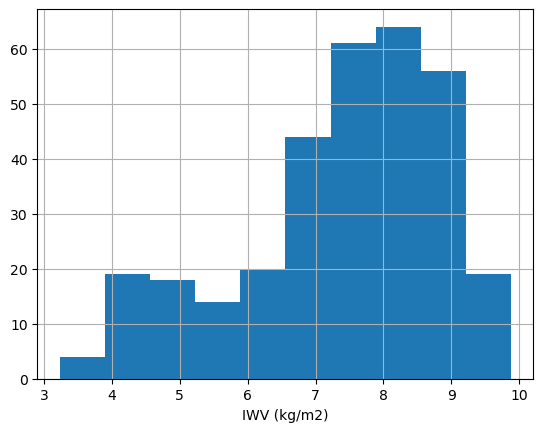

In [25]:
ax1=iwv_ocean.hist()
ax1.set_xlabel("IWV (kg/m2)")

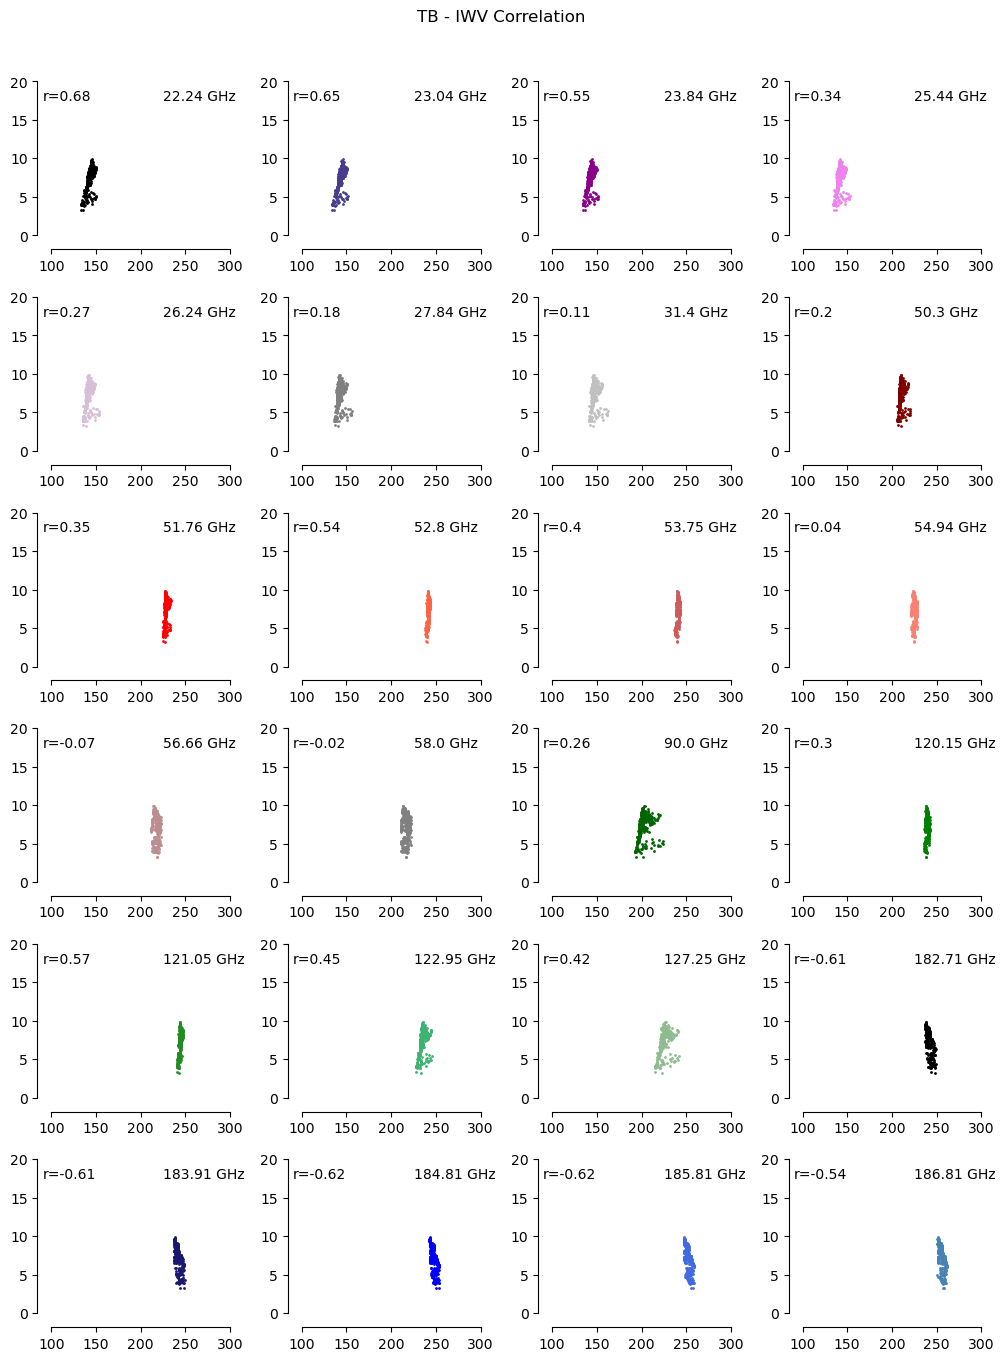

In [26]:
#### Hydrometeor histogram
import seaborn as sns
tb_hmp_fig,axes=plt.subplots(6,4,figsize=(12,16))

i=0
colors_list=["k","darkslateblue","darkmagenta","violet","thistle","gray","silver",#
            "maroon","red","tomato","indianred","salmon","rosybrown","grey",#
             "darkgreen","green","forestgreen","mediumseagreen","darkseagreen",#
            "k","midnightblue","blue","royalblue","steelblue","skyblue","grey"]
for ax in axes.flat:
    tb=tb_da[:,i]
    ax.scatter(tb,iwv,s=1,c=colors_list[i])
    ax.set_ylim([0,20])
    ax.set_xlim([100,300])
    ax.text(225,17.5,s=str(round(tb_da.freq.values[i],2))+" GHz")
    corr, _ = pearsonr(tb, iwv)
    ax.text(90,17.5,"r="+str(round(corr,2)))
    i+=1
    
sns.despine(offset=10)               
tb_hmp_fig.subplots_adjust(hspace=0.4,wspace=0.4)
tb_hmp_fig.suptitle("TB - IWV Correlation",y=0.925)
tb_hmp_fig.savefig(ar_plot_path+"TB_IWV_Corr_"+date_to_analyse+".png",dpi=300,bbox_inches="tight")

### Prepare Hydrometeorpaths (LWP,IWP,RWP,SWP)

In [35]:
lwp=pd.Series(data=era5_ds["lwp"][:,0,height_idx],index=sea_ice_mask.index)
iwp=pd.Series(data=era5_ds["iwp"][:,0,height_idx],index=sea_ice_mask.index)
rwp=pd.Series(data=era5_ds["rwp"][:,0,height_idx],index=sea_ice_mask.index)
swp=pd.Series(data=era5_ds["swp"][:,0,height_idx],index=sea_ice_mask.index)
hmp_ocean={}
hmp_ocean["lwp"]=lwp[open_ocean==1]*1000
hmp_ocean["iwp"]=iwp[open_ocean==1]*1000
hmp_ocean["rwp"]=rwp[open_ocean==1]*1000
hmp_ocean["swp"]=swp[open_ocean==1]*1000

### Plot Hydrometeorpaths Histograms

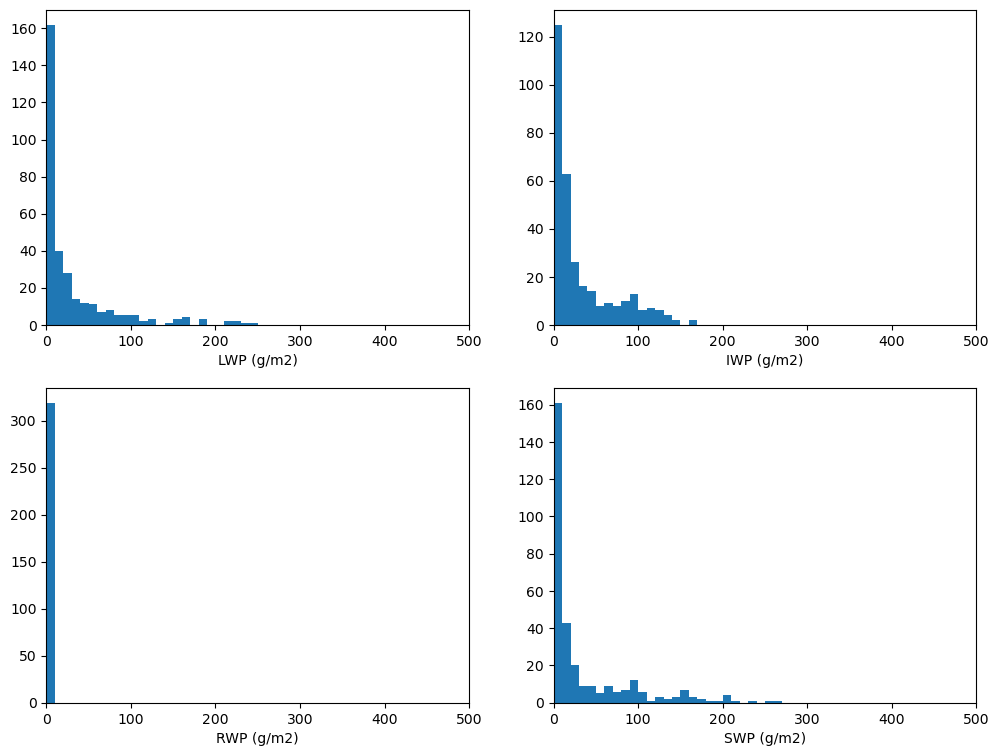

In [30]:
def plot_hydrometeor_distribution(hmp_ocean):
    fig=plt.figure(figsize=(12,9))
    # Four Paths, so for subplots
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)
    ax3=fig.add_subplot(223)
    ax4=fig.add_subplot(224)
    # LWP
    ax1.hist(lwp_ocean,bins=np.linspace(0,300,31))
    ax1.set_xlabel("LWP (g/m2)")
    ax1.set_xlim([0,500])
    #IWP
    ax2.hist(iwp_ocean,bins=np.linspace(0,300,31))
    ax2.set_xlabel("IWP (g/m2)")
    ax2.set_xlim([0,500])
    #RWP
    ax3.hist(rwp_ocean,bins=np.linspace(0,300,31))
    ax3.set_xlabel("RWP (g/m2)")
    ax3.set_xlim([0,500])
    #SWP 
    ax4.hist(swp_ocean,bins=np.linspace(0,300,31))
    ax4.set_xlabel("SWP (g/m2)")
    ax4.set_xlim([0,500])
    fig.savefig(ar_plot_path+"HMP_dist_"+date_to_analyse+".png",dpi=200)

### TB Hist and LWP correlation

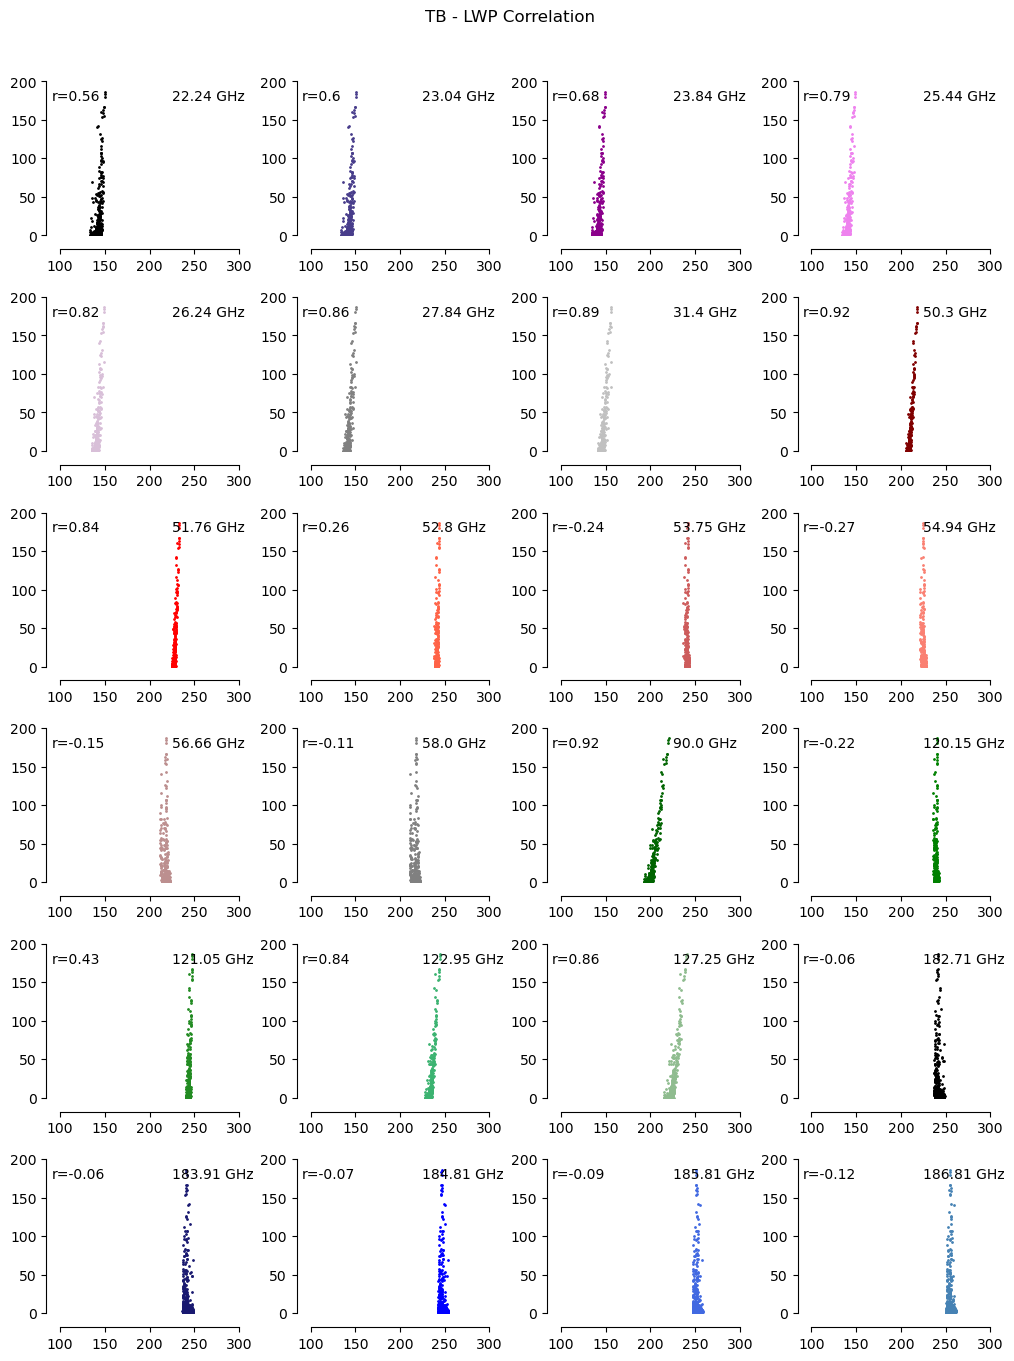

In [31]:
tb_hmp_fig,axes=plt.subplots(6,4,figsize=(12,16))

i=0
colors_list=["k","darkslateblue","darkmagenta","violet","thistle","gray","silver",#
            "maroon","red","tomato","indianred","salmon","rosybrown","grey",#
             "darkgreen","green","forestgreen","mediumseagreen","darkseagreen",#
            "k","midnightblue","blue","royalblue","steelblue","skyblue","grey"]
for ax in axes.flat:
    tb=tb_da[:,i]
    ax.scatter(tb,lwp*1000,s=1,c=colors_list[i])
    ax.set_ylim([0,200])
    ax.set_xlim([100,300])
    ax.text(225,175,s=str(round(tb_da.freq.values[i],2))+" GHz")
    corr, _ = pearsonr(tb, lwp)
    ax.text(90,175,"r="+str(round(corr,2)))
    i+=1
    
sns.despine(offset=10)               
tb_hmp_fig.subplots_adjust(hspace=0.4,wspace=0.4)
tb_hmp_fig.suptitle("TB - LWP Correlation",y=0.925)
tb_hmp_fig.savefig(ar_plot_path+"TB_LWP_Corr_"+date_to_analyse+".png",dpi=300,bbox_inches="tight")

### TB Hist and RWP correlation

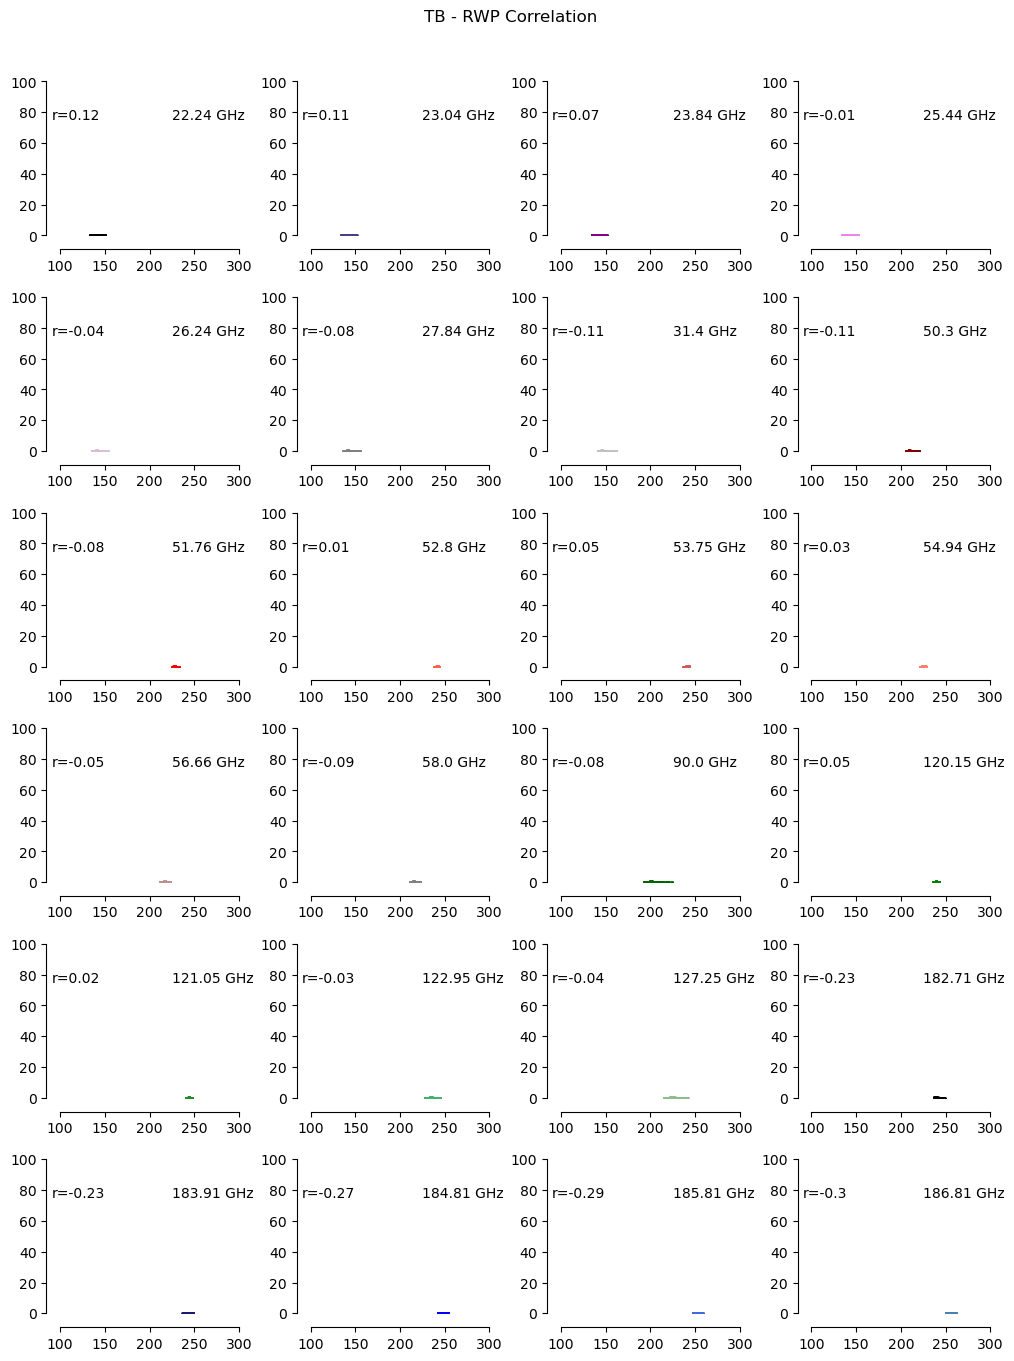

In [32]:
tb_hmp_fig,axes=plt.subplots(6,4,figsize=(12,16))

i=0
colors_list=["k","darkslateblue","darkmagenta","violet","thistle","gray","silver",#
            "maroon","red","tomato","indianred","salmon","rosybrown","grey",#
             "darkgreen","green","forestgreen","mediumseagreen","darkseagreen",#
            "k","midnightblue","blue","royalblue","steelblue","skyblue","grey"]
for ax in axes.flat:
    tb=tb_da[:,i]
    ax.scatter(tb,rwp*1000,s=1,c=colors_list[i])
    ax.set_ylim([0,100])
    ax.set_xlim([100,300])
    ax.text(225,75,s=str(round(tb_da.freq.values[i],2))+" GHz")
    corr, _ = pearsonr(tb, rwp)
    ax.text(90,75,"r="+str(round(corr,2)))
    i+=1
    
sns.despine(offset=10)               
tb_hmp_fig.subplots_adjust(hspace=0.4,wspace=0.4)
tb_hmp_fig.suptitle("TB - RWP Correlation",y=0.925)
tb_hmp_fig.savefig(ar_plot_path+"TB_RWP_Corr_"+date_to_analyse+".png",dpi=300,bbox_inches="tight")

### TB Hist and SWP correlation

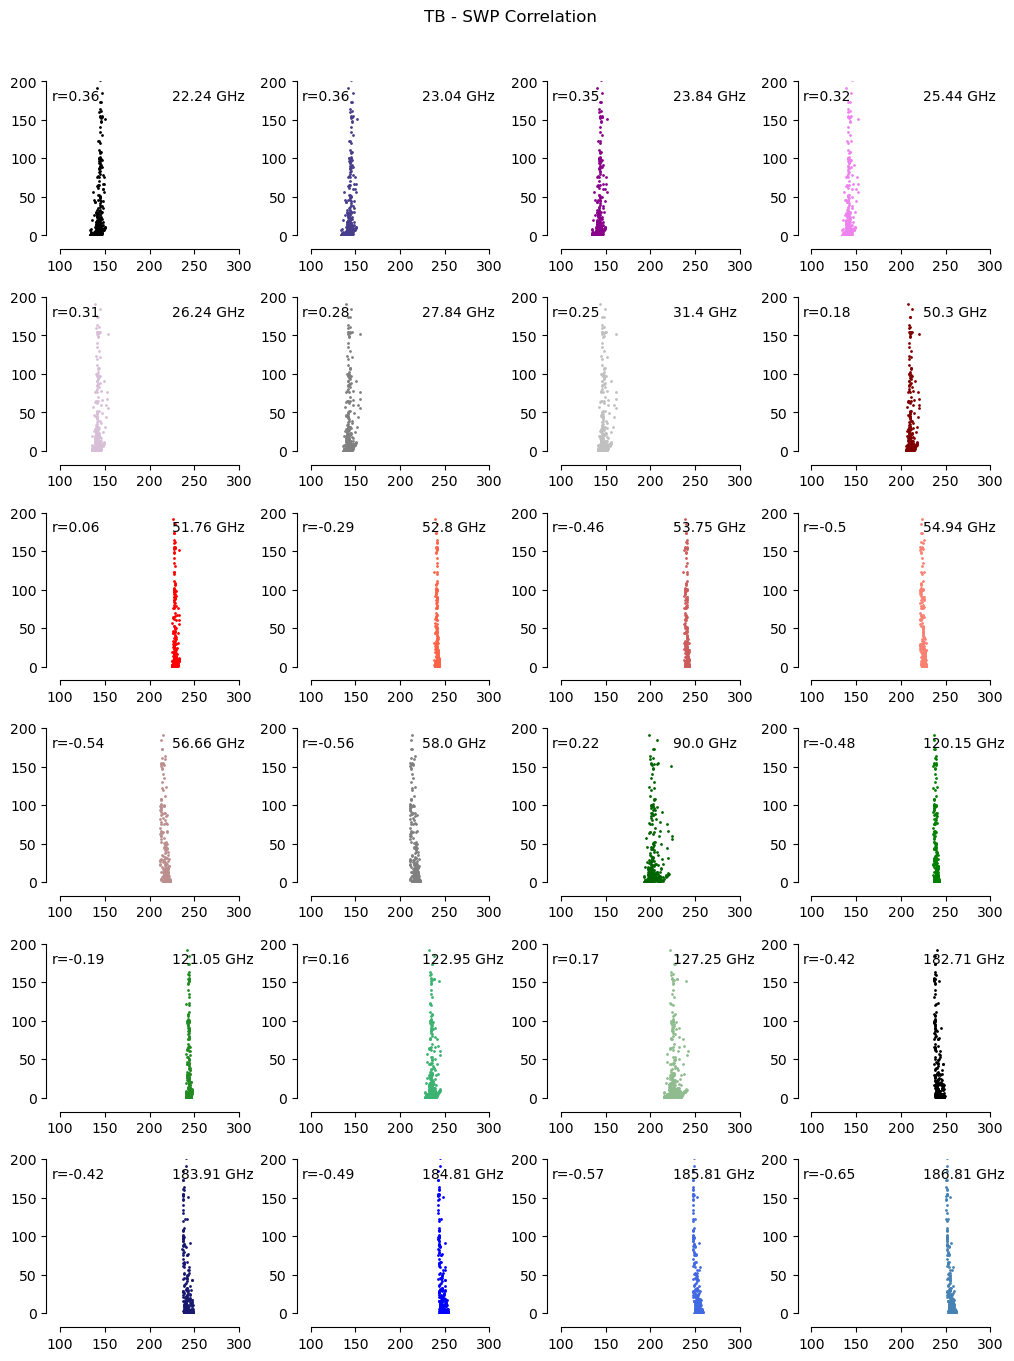

In [33]:
tb_hmp_fig,axes=plt.subplots(6,4,figsize=(12,16))

i=0
colors_list=["k","darkslateblue","darkmagenta","violet","thistle","gray","silver",#
            "maroon","red","tomato","indianred","salmon","rosybrown","grey",#
             "darkgreen","green","forestgreen","mediumseagreen","darkseagreen",#
            "k","midnightblue","blue","royalblue","steelblue","skyblue","grey"]
for ax in axes.flat:
    tb=tb_da[:,i]
    ax.scatter(tb,swp*1000,s=1,c=colors_list[i])
    ax.set_ylim([0,200])
    ax.set_xlim([100,300])
    ax.text(225,175,s=str(round(tb_da.freq.values[i],2))+" GHz")
    corr, _ = pearsonr(tb, swp)
    ax.text(90,175,"r="+str(round(corr,2)))
    i+=1
    
sns.despine(offset=10)               
tb_hmp_fig.subplots_adjust(hspace=0.4,wspace=0.4)
tb_hmp_fig.suptitle("TB - SWP Correlation",y=0.925)
tb_hmp_fig.savefig(ar_plot_path+"TB_SWP_Corr_"+date_to_analyse+".png",dpi=300,bbox_inches="tight")

### TB Hist and IWP correlation

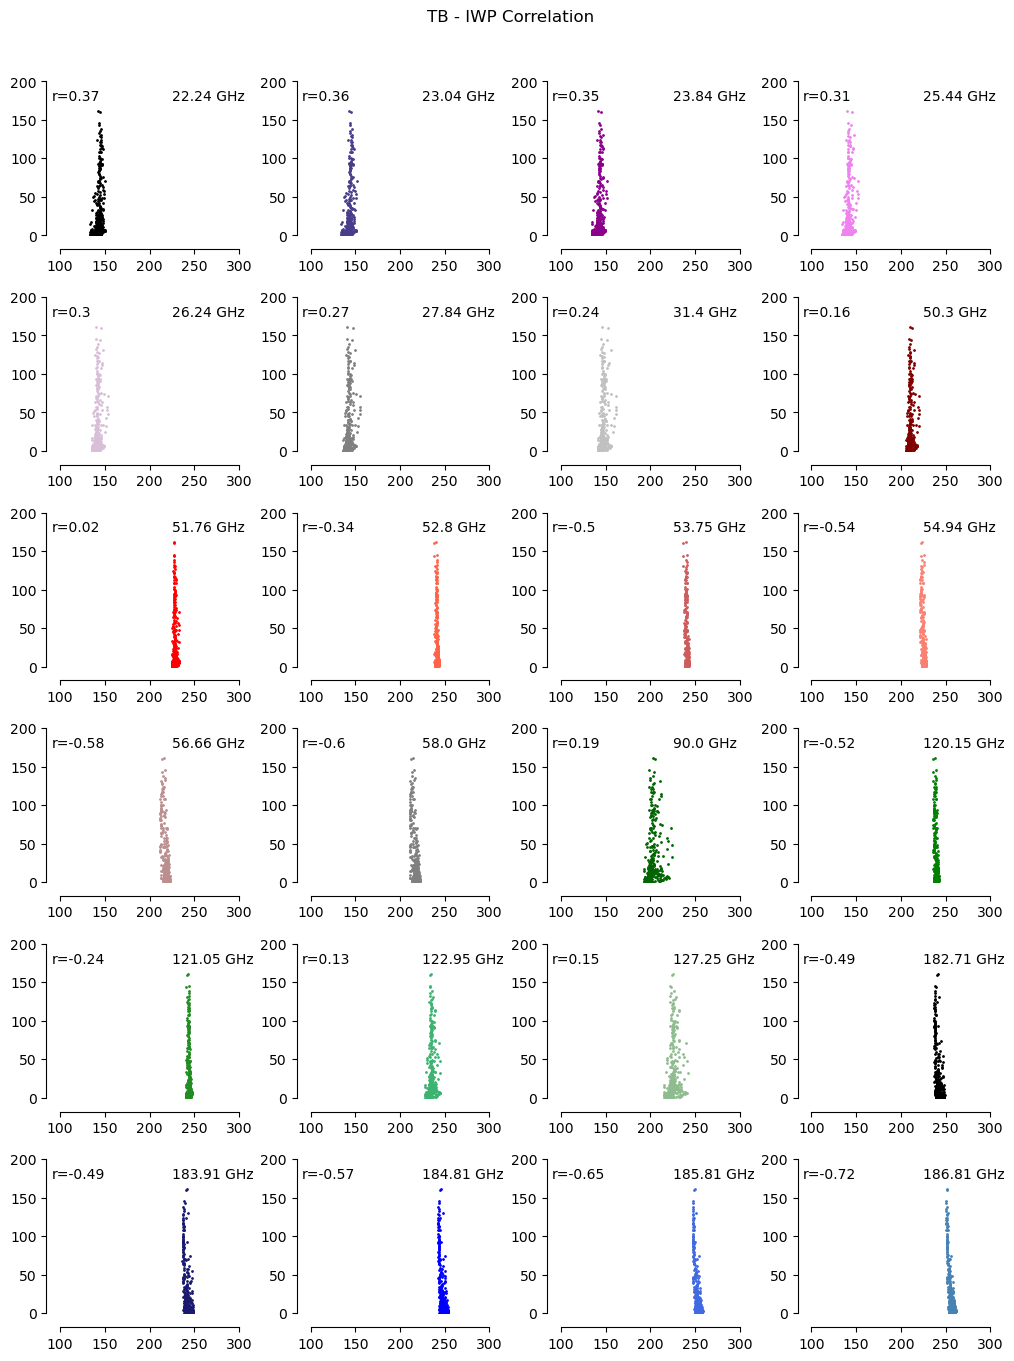

In [34]:
tb_hmp_fig,axes=plt.subplots(6,4,figsize=(12,16))

i=0
colors_list=["k","darkslateblue","darkmagenta","violet","thistle","gray","silver",#
            "maroon","red","tomato","indianred","salmon","rosybrown","grey",#
             "darkgreen","green","forestgreen","mediumseagreen","darkseagreen",#
            "k","midnightblue","blue","royalblue","steelblue","skyblue","grey"]
for ax in axes.flat:
    tb=tb_da[:,i]
    ax.scatter(tb,iwp*1000,s=1,c=colors_list[i])
    ax.set_ylim([0,200])
    ax.set_xlim([100,300])
    ax.text(225,175,s=str(round(tb_da.freq.values[i],2))+" GHz")
    corr, _ = pearsonr(tb, iwp)
    ax.text(90,175,"r="+str(round(corr,2)))
    i+=1
    
sns.despine(offset=10)               
tb_hmp_fig.subplots_adjust(hspace=0.4,wspace=0.4)
tb_hmp_fig.suptitle("TB - IWP Correlation",y=0.925)
tb_hmp_fig.savefig(ar_plot_path+"TB_IWP_Corr_"+date_to_analyse+".png",dpi=300,bbox_inches="tight")